In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from models import *
from opt import encode
from tqdm import tnrange

sns.set_context('paper', font_scale=1.5)

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0
TensorFlow Check Passed


Example Sentences

Goto(John, Doctor), Checkin(John, None), Wait(John, None), Read(John, Magazine), Treat(Doctor, John)

Goto(Bill, Dentist), Checkin(Bill, None), Wait(Bill, None), Read(Bill, Magazine), Treat(Dentist, Bill)

Goto(Natasha, Chiropractor), Checkin(Natasha, None), Wait(Natasha, None), Read(Natasha, Magazine), Treat(Chiropractor, Natasha)



BuyTicket(Sarah, Play), Goto(Sarah, Playhouse), Buy(Sarah, Food), FindSeat(Sarah, None), Watch(Sarah, Play)

BuyTicket(Jill, Movie), Goto(Jill, MovieTheater), Buy(Jill, Food),  FindSeat(Sarah, None), Watch(Jill, Movie)

BuyTicket(Nikolai, Opera), Goto(Nikolai, Operahouse), Buy(Nikolai, Drink),  FindSeat(Nikolai, None), Watch(Nikolai, Opera)

In [2]:
from opt import plate_formula, embed, encode, decode

np.random.seed(0)

# figure out how many dimensions we need using plates formula
n = 26
k = 6;      # maximum number of terms to be combined
err = 0.1; # error probability

d = plate_formula(n, k, err)
print d

def embed(d):
    return np.random.randn(1, d) / (np.sqrt(d))


a0 =[
    ['Goto', 'John', 'Doctor'],
    ['Checkin', 'John', 'None'],
    ['Read', 'John', 'Magazine'],
    ['Treat', 'Doctor', 'John']
]

a1 = [
    ['Goto', 'Bill', 'Dentist'], 
    ['Read', 'Bill', 'Magazine'],
    ['Wait', 'Bill', 'None'],
    ['Treat', 'Dentist', 'Bill']
]

a2 = [
    ['Goto', 'Natasha', 'Dentist'], 
    ['Checkin', 'Natasha', 'None'],
    ['Wait', 'Natasha', 'Magazine'],
    ['Treat', 'Chiropractor', 'Natasha']
]

b0 = [
    ['BuyTicket', 'Jill', 'Movie'],
    ['FindSeat', 'Jill', 'None'],
    ['Buy', 'Jill', 'Food'],
    ['Watch', 'Jill', 'Movie']
]

c0 = [
    ['WakeUp', 'Sarah', 'None'],
    ['GetDressed', 'Sarah', 'None'],
    ['Eat', 'Sarah', 'Toast'],
    ['Leave', 'Sarah', 'None']
    
]


# create an a version and b version of each script
scripts_1 = [a0, b0, c0]
scripts_2 = [a0, a1, b0]
scripts_3 = [a0, a1, a2]

# generate the embeddings as a function
def gen_embeddings():
    verb_property = embed(d)
    agent_property = embed(d)
    object_property = embed(d) * 0.5 + agent_property * 0.5

    words = {
        'Goto': (embed(d) + verb_property),
        'Checkin':  (embed(d) + verb_property),
        'Wait': (embed(d) + verb_property),
        'Read': (embed(d) + verb_property),
        'Treat': (embed(d) + verb_property),
        'BuyTicket': (embed(d) + verb_property),
        'FindSeat': (embed(d) + verb_property),
        'Buy': (embed(d) + verb_property),
        'Watch': (embed(d) + verb_property),
        'WakeUp': (embed(d) + verb_property),
        'GetDressed': (embed(d) + verb_property),
        'Eat': (embed(d) + verb_property),
        'Leave': (embed(d) + verb_property),
        'John':(embed(d) + agent_property),
        'Bill': (embed(d) + agent_property),
        'Natasha': (embed(d) + agent_property),
        'Magazine': (embed(d) + object_property),
        'Doctor': (embed(d) + agent_property),
        'Dentist': (embed(d) + agent_property),
        'Chiropractor': (embed(d) + agent_property),
        'Jill': (embed(d) + agent_property),
        'Movie': (embed(d) + object_property),
        'Food': (embed(d) + object_property),
        'Sarah': (embed(d) + agent_property),
        'Toast': (embed(d) + object_property),
        'None': embed(d)*2,
    }

    roles = {
        'Agent': embed(d),
        'Patient': embed(d),
        'Verb': embed(d)
    }


    def encode_sentence(s):
        return encode(words[s[0]], roles['Verb']) +\
                encode(words[s[1]], roles['Agent']) +\
                encode(words[s[2]], roles['Patient'])

    def encode_scripts(scripts):
        x_train = []
        for script in scripts:
            _x_train = []
            for s in script:
                _x_train.append(encode_sentence(s))
            x_train.append(np.concatenate(_x_train, axis=0))
        return x_train

    x_train_1 = encode_scripts(scripts_1)
    x_train_2 = encode_scripts(scripts_2)
    x_train_3 = encode_scripts(scripts_3)

    # the probe for all of these is Wait(John, None)
    # probe queues
    valid_unseen = ['Wait', 'John', 'None']
    valid_seen = ['Read', 'John', 'Magazine']
    invalid_unseen = ['GetDressed', 'John', 'None']

    x_valid = encode_sentence(valid_unseen)
    x_seen = encode_sentence(valid_seen)
    x_invalid = encode_sentence(invalid_unseen)
    
    return x_train_1, x_train_2, x_train_3, x_valid, x_seen, x_invalid

gamma=2.5
x_train_1, x_train_2, x_train_3, x_valid, x_seen, x_invalid = gen_embeddings()

print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_valid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_valid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_valid, axis=1) * gamma)

print 
print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_invalid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_invalid, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_invalid, axis=1) * gamma)

print 
print logsumexp(-np.linalg.norm(np.concatenate(x_train_1) - x_seen, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_2) - x_seen, axis=1) * gamma)
print logsumexp(-np.linalg.norm(np.concatenate(x_train_3) - x_seen, axis=1) * gamma)

185
-2.427228171947773
-2.2979647428238437
-2.2601142252897986

-2.131232275115158
-2.5637819896747835
-2.503730388337112

0.035695550186014606
0.07630284234588441
0.0777966825684047


## Segment and Train

In [3]:
# SEM parameters
# df0 = 1.0
# mode = 0.4
df0 = 10.
mode = 0.2
scale0 = (mode * (df0 + 2)) / df0
print scale0

lmda = 1.0  # stickyness parameter
alfa = 10.001  # concentration parameter


f_class = GRUEvent
f_opts=dict(var_scale0=scale0, var_df0=df0, dropout=0.5,
            prior_log_prob=0, t=4)#, n_hidden = int(np.floor(d/2.)))

sem_kwargs = dict(lmda=lmda, alfa=alfa, f_class=f_class, f_opts=f_opts)


0.24


In [4]:
# First, run all of the models
sem_model_1 = SEM(**sem_kwargs)
sem_model_1.run_w_boundaries(x_train_1)
print sem_model_1.results.e_hat

print sem_model_1.results.log_like

print sem_model_1.results.log_prior

Run SEM: 100%|██████████| 3/3 [00:10<00:00,  4.22s/it]

[0 0 1]
[[  0.                 -inf         -inf]
 [116.69309429   0.                 -inf]
 [-26.79480487   0.                 -inf]]
[[2.30268509       -inf       -inf]
 [1.60943791 2.30268509       -inf]
 [2.19722458 2.30268509       -inf]]


In [5]:
sem_model_2 = SEM(**sem_kwargs)
sem_model_2.run_w_boundaries(x_train_2)
print sem_model_2.results.e_hat


sem_model_2.results.log_like

Run SEM: 100%|██████████| 3/3 [00:08<00:00,  3.04s/it]

[0 0 0]


array([[  0.        ,         -inf,         -inf],
       [110.44877911,   0.        ,         -inf],
       [183.75579828,   0.        ,         -inf]])

In [6]:
sem_model_3 = SEM(**sem_kwargs)
sem_model_3.run_w_boundaries(x_train_3)
print sem_model_3.results.e_hat

sem_model_3.results.log_like

Run SEM: 100%|██████████| 3/3 [00:10<00:00,  3.86s/it]

[0 0 0]


array([[  0.        ,         -inf,         -inf],
       [114.51100452,   0.        ,         -inf],
       [213.60905216,   0.        ,         -inf]])

## Memory recontruction

In [7]:
# set the parameters for the Gibbs sampler
gibbs_kwargs = dict(
    memory_alpha = 10.0,
    memory_lambda = 100.0,
    memory_epsilon = np.exp(-100),
    b = 1,  # re-defined here for completeness
    tau = 0.15,  # ibid
    n_samples = 250,
    n_burnin = 100,
    progress_bar=False,
)

epsilon_e = 0.75


def reconstruct_and_score(x_train, sem_model):


    # create the corrupted memory trace
    n, d = np.concatenate(x_train).shape
    y_mem = []
    for t in range(n):
        x_mem = x_train[t / 4][t % 4, :] + np.random.randn(d) * gibbs_kwargs['tau']
        e_mem = [None, sem_model.results.e_hat[t / 4]][np.random.rand() < epsilon_e]
        t_mem = t + np.random.randint(-gibbs_kwargs['b'], gibbs_kwargs['b'] + 1)
        y_mem.append([x_mem, e_mem, t_mem])

    # run the reconstruction
    # sample from memory
    gibbs_kwargs['y_mem'] = y_mem
    gibbs_kwargs['sem_model'] = sem_model
    y_samples, e_samples, x_samples = gibbs_memory_sampler(**gibbs_kwargs)
    
    
    
    valid_vs_invalid = []
    valid_vs_seen = []
    seen_vs_invalid = []
    for ii in range(len(x_samples)):
        x0_sample = x_samples[0]

        # evaluate Gaussian Kernel functions with gamma 
        gamma = 2.5  #prev 7.5
        valid_vs_invalid.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_valid, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_invalid, axis=1) * gamma)
        )

        valid_vs_seen.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_valid, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_seen, axis=1) * gamma)

        )

        seen_vs_invalid.append(
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_seen, axis=1) * gamma) <
            -logsumexp(-np.linalg.norm(x_samples[ii] - x_invalid, axis=1) * gamma)

        )

    valid_vs_invalid = np.mean(valid_vs_invalid)
    valid_vs_seen = np.mean(valid_vs_seen)
    seen_vs_invalid = np.mean(seen_vs_invalid)
    accuracy = np.mean([np.mean([yi != None for yi in ys ]) for ys in y_samples])
    
#     print "Valid vs Invalid {}".format(valid_vs_invalid)
#     print "Valid vs Seen    {}".format(valid_vs_seen)
#     print "Invalid vs Seen  {}".format(1-seen_vs_invalid)
    
    return valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy

In [8]:
results = []
n_batch = 25
for ii in tnrange(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_1, progress_bar=False)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy =  \
        reconstruct_and_score(x_train_1, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 1,
        'Batch': ii
    })

In [9]:
for ii in tnrange(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_2)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy  =  \
        reconstruct_and_score(x_train_2, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 2,
        'Batch': ii
    })

Run SEM: 100%|██████████| 3/3 [00:42<00:00, 14.39s/it]


In [10]:
for ii in range(n_batch):
    sem_model = SEM(**sem_kwargs)
    sem_model.run_w_boundaries(x_train_3)
    valid_vs_invalid, valid_vs_seen, seen_vs_invalid, accuracy =  reconstruct_and_score(x_train_3, sem_model)
    results.append({
        'Accuracy': accuracy,
        'Valid vs Invalid': valid_vs_invalid,
        'Valid vs Seen': valid_vs_seen,
        'Seen vs Invalid': seen_vs_invalid, 
        'Number Clusters': len(set(sem_model.results.e_hat)),
        'Script Instances': 3,
        'Batch': ii
    })

Run SEM: 100%|██████████| 3/3 [00:52<00:00, 16.71s/it]


In [11]:
results = pd.DataFrame(results)

In [12]:
y = results.groupby('Script Instances').mean()['Valid vs Seen']
y_err = results.groupby('Script Instances').std()['Valid vs Seen'] / np.sqrt(8)

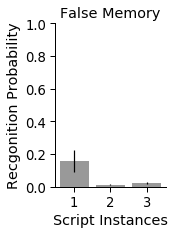

In [13]:
plt.figure(figsize=(2, 3))
plt.bar(range(3), y, facecolor='k', alpha=0.4)
plt.errorbar(range(3), y, y_err, ls=' ', c='k')
plt.xlabel('Script Instances')
plt.xticks(range(0, 3), [1, 2, 3])
plt.ylabel('Recgonition Probability')
plt.ylim([0, 1])
plt.title('False Memory')
sns.despine()

In [14]:
results.groupby('Script Instances').mean()

,Accuracy,Batch,Number Clusters,Seen vs Invalid,Valid vs Invalid,Valid vs Seen
Script Instances,,,,,,
1,0.93308,12.0,1.16,0.81888,0.43872,0.15552
2,0.97128,12.0,1.00,0.99408,0.77200,0.01216
3,0.96712,12.0,1.00,0.98992,0.85472,0.02304


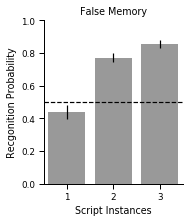

In [16]:
with sns.plotting_context('paper'):
    y = results.groupby('Script Instances').mean()['Valid vs Invalid']
    y_err = results.groupby('Script Instances').std()['Valid vs Invalid'] / np.sqrt(8)

    plt.figure(figsize=(2.5, 3))
    plt.bar(range(3), y, facecolor='k', alpha=0.4)
    plt.errorbar(range(3), y, y_err, ls=' ', c='k')
    plt.xlabel('Script Instances')
    plt.xticks(range(0, 3), [1, 2, 3])
    plt.ylabel('Recgonition Probability')
    plt.ylim([0, 1])
    plt.title('False Memory')
    plt.plot([-0.5, 2.5], [0.5, 0.5], ls='--', c='k')
    plt.xlim([-0.5, 2.5])
    sns.despine()
    plt.savefig('bower_new.png', bbox_inches='tight', dpi=300)